In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


In [ ]:
# Download stock data from Yahoo Finance
tickers = ["INFY.NS","TCS.NS","ITC.NS" ,"^NSEI"]  # Define the tickers for the stocks and the Nifty index
stock_data = yf.download(tickers, period="10y")  # Download 10 years of data

# Extract the 'Close' prices for analysis
stock_data_close = stock_data['Close']

stock_data_close.dropna(inplace=True)  # Drop rows with missing values



[*********************100%***********************]  4 of 4 completed
<ipython-input-2-556ead0d1d2c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_close.dropna(inplace=True)  # Drop rows with missing values


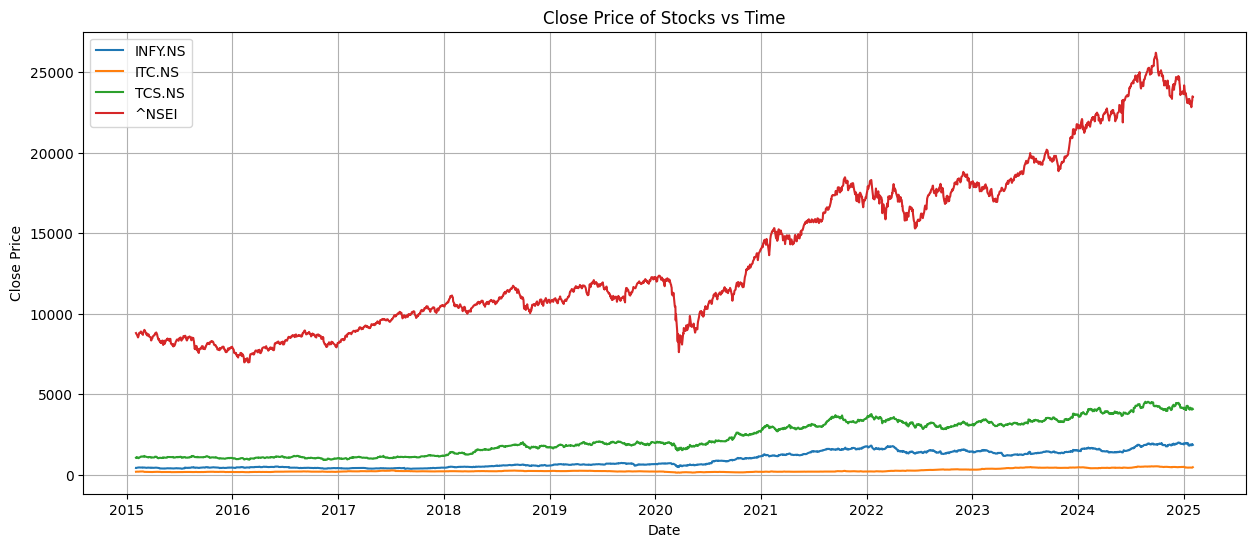

In [ ]:
# Plot the Close Price for each stock
plt.figure(figsize=(15, 6))
for column in stock_data_close.columns:
    plt.plot(stock_data_close.index, stock_data_close[column], label=column)  # Plot each stock's Close price
plt.title("Close Price of Stocks vs Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Augmented Dickey-Fuller (ADF) test to check for stationarity
def adf_test(series):
    """Perform the Augmented Dickey-Fuller test for stationarity."""
    result = adfuller(series)
    return {'ADF Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]}

# Perform ADF test on each stock's Close price
results = {column: adf_test(stock_data_close[column]) for column in stock_data_close.columns}

# Print ADF test results for each stock
print("ADF Test Results for Stationarity:")
for column, result in results.items():
    print(f"{column}: {result}")


ADF Test Results for Stationarity:
INFY.NS: {'ADF Statistic': -0.17075258007694158, 'p-value': 0.9419192214154504, 'Critical Values': {'1%': -3.4330099487687264, '5%': -2.8627151430515654, '10%': -2.5673955755408095}}
ITC.NS: {'ADF Statistic': 0.22065875669129703, 'p-value': 0.9733967667962304, 'Critical Values': {'1%': -3.433019722288691, '5%': -2.862719458977711, '10%': -2.567397873407599}}
TCS.NS: {'ADF Statistic': -0.35783718691626665, 'p-value': 0.9169040275391991, 'Critical Values': {'1%': -3.4330088672375108, '5%': -2.8627146654531828, '10%': -2.5673953212600824}}
^NSEI: {'ADF Statistic': 0.39964386814991537, 'p-value': 0.9814816187066133, 'Critical Values': {'1%': -3.4330088672375108, '5%': -2.8627146654531828, '10%': -2.5673953212600824}}


In [ ]:
# Differencing the data to make it stationary if necessary
for column in stock_data_close.columns:
    stock_data_close[f"{column}_diff"] = stock_data_close[column].diff(2)  # Differencing the data
stock_data_close.dropna(inplace=True)  # Drop NA values generated due to differencing

# Re-run ADF test after differencing
results_with_retest = {column: adf_test(stock_data_close[column]) for column in stock_data_close.columns if column.endswith('_diff')}
print("\nADF Test Results After Differencing:")
for column, result in results_with_retest.items():
    print(f"{column}: {result}")


<ipython-input-5-9dca68045fc4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_close[f"{column}_diff"] = stock_data_close[column].diff(2)  # Differencing the data
<ipython-input-5-9dca68045fc4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data_close[f"{column}_diff"] = stock_data_close[column].diff(2)  # Differencing the data
<ipython-input-5-9dca68045fc4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index


ADF Test Results After Differencing:
INFY.NS_diff: {'ADF Statistic': -9.205096080607557, 'p-value': 1.9545863830191383e-15, 'Critical Values': {'1%': -3.4330405929799293, '5%': -2.862728675299008, '10%': -2.5674027803295183}}
ITC.NS_diff: {'ADF Statistic': -8.832156074845448, 'p-value': 1.75793869380191e-14, 'Critical Values': {'1%': -3.4330405929799293, '5%': -2.862728675299008, '10%': -2.5674027803295183}}
TCS.NS_diff: {'ADF Statistic': -10.484451026927857, 'p-value': 1.1903612697503152e-18, 'Critical Values': {'1%': -3.4330405929799293, '5%': -2.862728675299008, '10%': -2.5674027803295183}}
^NSEI_diff: {'ADF Statistic': -8.91670449065804, 'p-value': 1.0678927776079911e-14, 'Critical Values': {'1%': -3.4330405929799293, '5%': -2.862728675299008, '10%': -2.5674027803295183}}


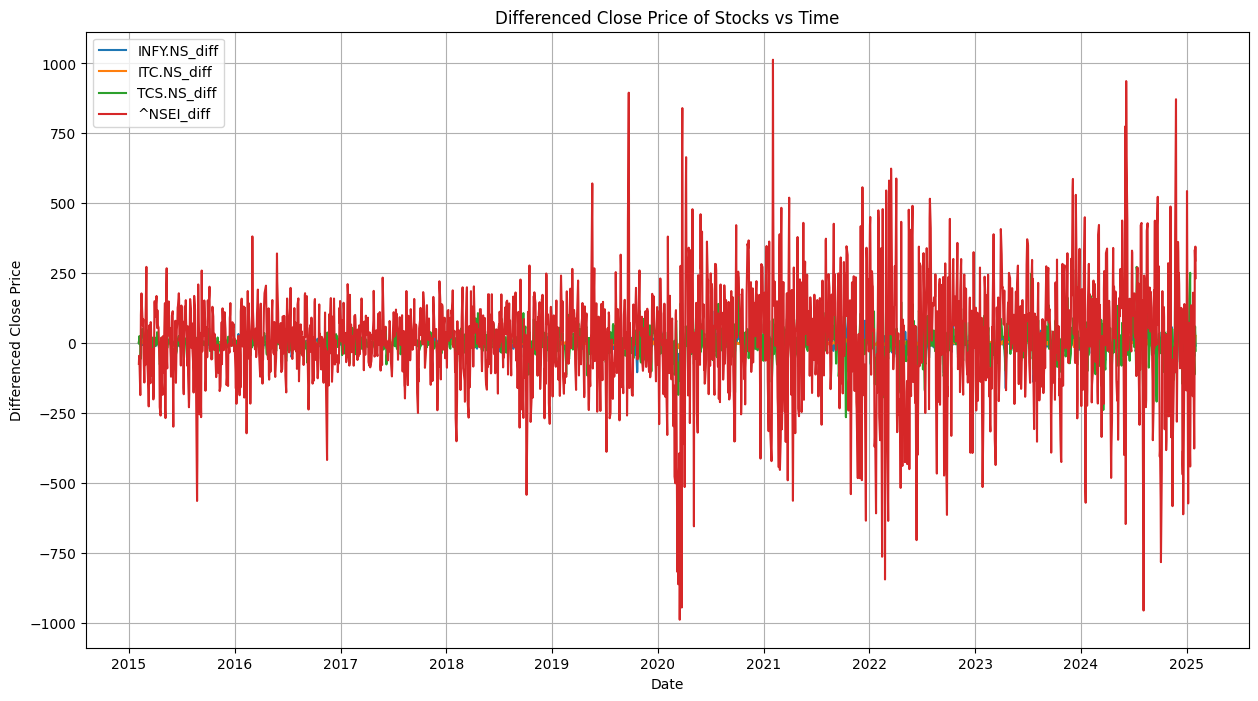

In [ ]:
# Plot Differenced Close Prices
plt.figure(figsize=(15, 8))
for column in stock_data_close.columns:
    if column.endswith('_diff'):  # Only plot the differenced columns
        plt.plot(stock_data_close.index, stock_data_close[column], label=column)
plt.title("Differenced Close Price of Stocks vs Time")
plt.xlabel("Date")
plt.ylabel("Differenced Close Price")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 1400x800 with 0 Axes>

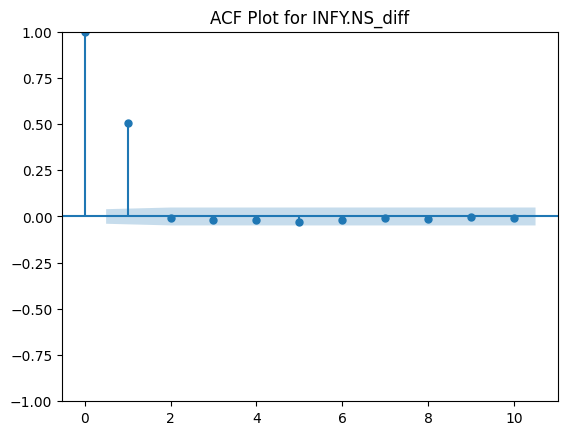

<Figure size 1400x800 with 0 Axes>

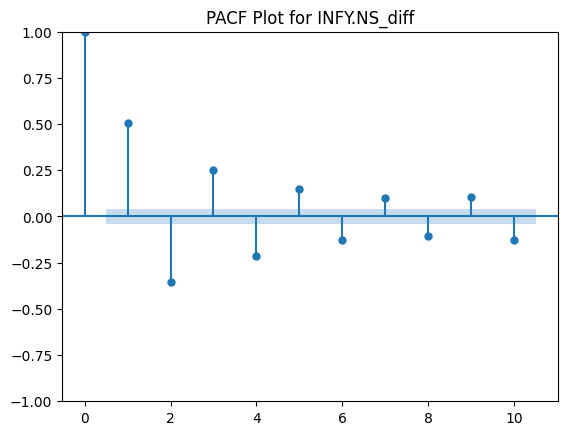

<Figure size 1400x800 with 0 Axes>

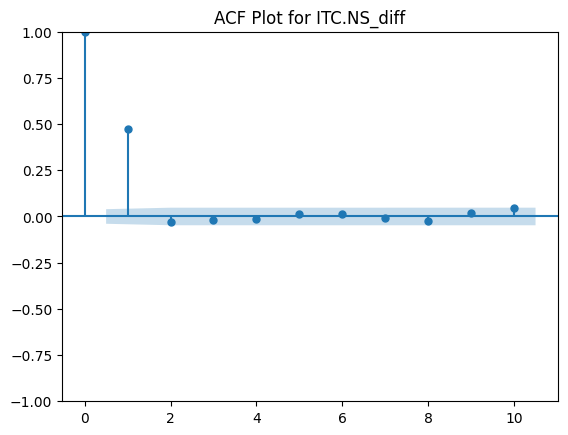

<Figure size 1400x800 with 0 Axes>

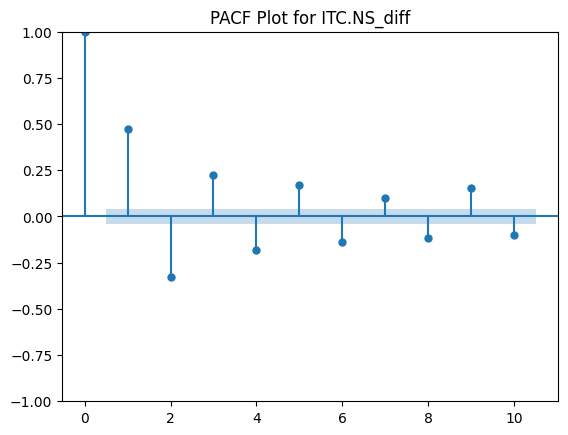

<Figure size 1400x800 with 0 Axes>

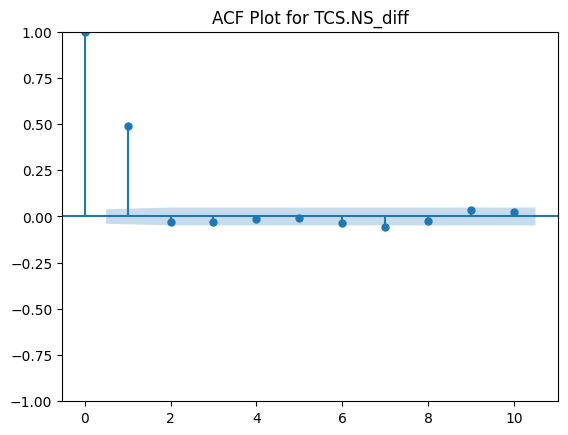

<Figure size 1400x800 with 0 Axes>

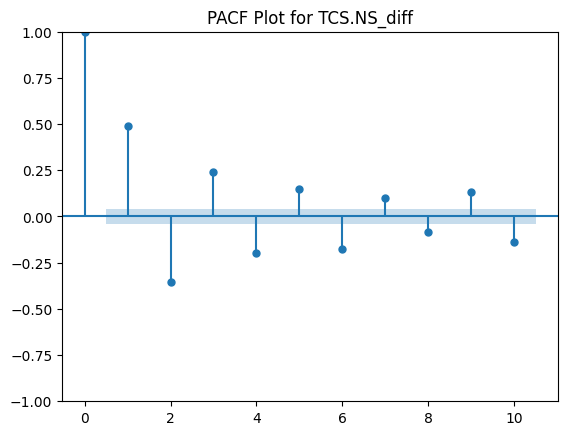

<Figure size 1400x800 with 0 Axes>

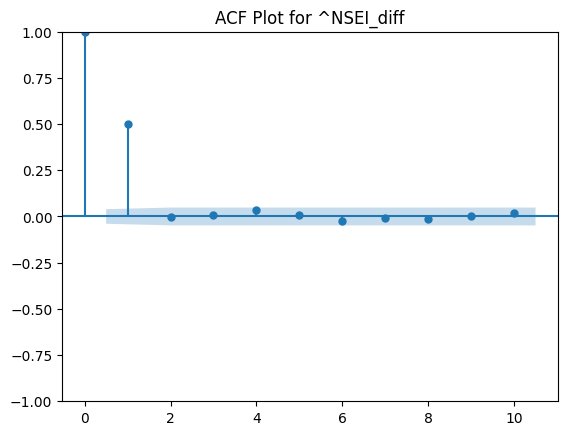

<Figure size 1400x800 with 0 Axes>

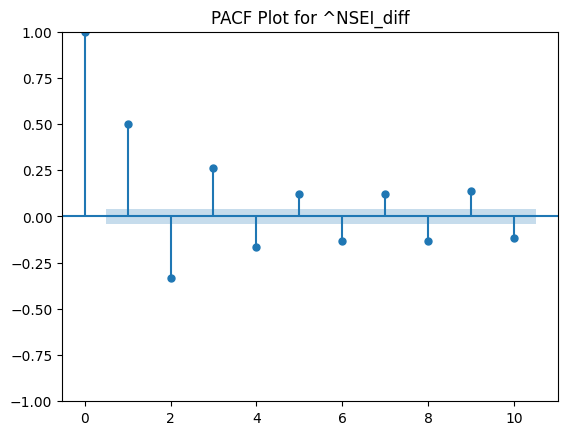

In [ ]:
# ACF and PACF plots to determine ARIMA model parameters
for column in stock_data_close.columns:
    if column.endswith('_diff'):  # Use only differenced data for ACF/PACF
        plt.figure(figsize=(14, 8))
        plot_acf(stock_data_close[column], lags=10)
        plt.title(f"ACF Plot for {column}")
        plt.show()

        plt.figure(figsize=(14, 8))
        plot_pacf(stock_data_close[column], lags=10)
        plt.title(f"PACF Plot for {column}")
        plt.show()


In [ ]:
# Train-test split for ARIMA model
train_size = 0.8  # Using 80% of the data for training and 20% for testing
train_data, test_data = train_test_split(stock_data_close, test_size=(1 - train_size), shuffle=False)

In [ ]:


# ARIMA model fitting for each stock (excluding differenced columns)
arima_models = {}
for column in train_data.columns:
    if not column.endswith('_diff'):
        model = ARIMA(train_data[column], order=(1, 1, 2))  # ARIMA(1,1,1) as example, adjust as needed
        model_fit = model.fit()  # Fit the ARIMA model
        arima_models[column] = model_fit  # Store the fitted model
        print(f"ARIMA Model Summary for {column}:")
        print(model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA Model Summary for INFY.NS:
                               SARIMAX Results                                
Dep. Variable:                INFY.NS   No. Observations:                 1968
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -8038.376
Date:                Sat, 01 Feb 2025   AIC                          16084.752
Time:                        17:31:28   BIC                          16107.089
Sample:                             0   HQIC                         16092.961
                               - 1968                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8514      0.060    -14.233      0.000      -0.969      -0.734
ma.L1          0.8859      0.062     14.292      0.000       0.764       1.007
ma.L2         -0.00

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA Model Summary for ITC.NS:
                               SARIMAX Results                                
Dep. Variable:                 ITC.NS   No. Observations:                 1968
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -5101.250
Date:                Sat, 01 Feb 2025   AIC                          10210.501
Time:                        17:31:33   BIC                          10232.838
Sample:                             0   HQIC                         10218.709
                               - 1968                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8534      0.221      3.861      0.000       0.420       1.287
ma.L1         -0.8640      0.226     -3.826      0.000      -1.307      -0.421
ma.L2         -0.003

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA Model Summary for TCS.NS:
                               SARIMAX Results                                
Dep. Variable:                 TCS.NS   No. Observations:                 1968
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -9572.729
Date:                Sat, 01 Feb 2025   AIC                          19153.458
Time:                        17:31:34   BIC                          19175.795
Sample:                             0   HQIC                         19161.667
                               - 1968                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2059      0.454      0.453      0.650      -0.685       1.097
ma.L1         -0.2162      0.455     -0.475      0.634      -1.107       0.675
ma.L2         -0.033

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

ARIMA Model Summary for ^NSEI:
                               SARIMAX Results                                
Dep. Variable:                  ^NSEI   No. Observations:                 1968
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -12318.273
Date:                Sat, 01 Feb 2025   AIC                          24644.547
Time:                        17:31:35   BIC                          24666.884
Sample:                             0   HQIC                         24652.756
                               - 1968                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0036     16.860      0.000      1.000     -33.041      33.048
ma.L1          0.0035     16.862      0.000      1.000     -33.045      33.052
ma.L2         -0.0009

In [ ]:
# ARIMA model fitting for each stock (excluding differenced columns)
arima_models_test = {}
for  column in test_data.columns:
    if not column.endswith('_diff'):
        model_test = ARIMA(test_data[column], order=(1, 1, 2))  # ARIMA(1,1,1) as example, adjust as needed
        model_fit_test = model_test.fit()  # Fit the ARIMA model
        arima_models_test[column] = model_fit_test  # Store the fitted model
        print(f"ARIMA Model Summary for {column}:")
        print(model_fit_test.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

ARIMA Model Summary for INFY.NS:
                               SARIMAX Results                                
Dep. Variable:                INFY.NS   No. Observations:                  493
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2247.126
Date:                Sat, 01 Feb 2025   AIC                           4502.253
Time:                        17:31:35   BIC                           4519.047
Sample:                             0   HQIC                          4508.847
                                - 493                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6733      0.601      1.121      0.262      -0.504       1.850
ma.L1         -0.6451      0.597     -1.081      0.280      -1.815       0.524
ma.L2         -0.04

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 ITC.NS   No. Observations:                  493
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1513.345
Date:                Sat, 01 Feb 2025   AIC                           3034.689
Time:                        17:31:35   BIC                           3051.483
Sample:                             0   HQIC                          3041.284
                                - 493                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6857      0.212     -3.242      0.001      -1.100      -0.271
ma.L1          0.6472      0.217      2.985      0.003       0.222       1.072
ma.L2         -0.1018      0.047     -2.150      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA Model Summary for ^NSEI:
                               SARIMAX Results                                
Dep. Variable:                  ^NSEI   No. Observations:                  493
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3227.800
Date:                Sat, 01 Feb 2025   AIC                           6463.600
Time:                        17:31:36   BIC                           6480.394
Sample:                             0   HQIC                          6470.195
                                - 493                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9802      0.097    -10.055      0.000      -1.171      -0.789
ma.L1          0.9240      0.102      9.079      0.000       0.724       1.123
ma.L2         -0.0593

In [ ]:
# Create LSTM dataset function
def create_lstm_dataset(data, look_back=10):
    """Prepare the data for LSTM by creating sequences."""
    X, y = [], []
    for i in range(len(data) - look_back - 1):  # Creating sequences with a specified look-back period
        a = data[i:(i + look_back)]
        X.append(a)
        y.append(data[i + look_back])  # The next value is the target for LSTM
    return np.array(X), np.array(y)


In [ ]:
def evaluate_model(true_values, predicted_values):
    """Evaluate the model performance with MAPE, RMSE, and MASE."""
    mape = mean_absolute_percentage_error(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    # MASE calculation (scaled by naive forecast)
    mase = np.mean(np.abs(true_values - predicted_values)) / np.mean(np.abs(true_values - np.mean(true_values)))
    return mape, rmse, mase


In [ ]:
# # Prepare data for LSTM models
scaler = MinMaxScaler(feature_range=(0, 1))  # Scale the residuals to [0, 1] for LSTM input
lstm_models = {}

for column in train_data.columns:
    if not column.endswith('_diff'):  # Apply the method only for non-differenced columns

        # Step 2: ARIMA predictions and residuals
        arima_predictions = model_fit.predict(start=0, end=len(train_data[column]) - 1, dynamic=False)
        residuals = train_data[column] - arima_predictions  # Calculate residuals

        # Add the residuals to the training data
        residual_column = f"{column}_residuals"
        train_data[residual_column] = residuals

        # Step 3: Scale the residuals
        train_data[residual_column] = scaler.fit_transform(train_data[residual_column].values.reshape(-1, 1))

        # Step 4: Create LSTM dataset using residuals
        look_back = 10  # Example: 10 previous observations to predict the next residual
        X, y = create_lstm_dataset(train_data[residual_column].values, look_back)
        X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshaping for LSTM input

        # Step 5: Define and train the LSTM model on the residuals
        lstm_model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
            Dropout(0.2),
            LSTM(50, return_sequences=True),
            Dropout(0.2),
            LSTM(50),
            Dropout(0.2),
            Dense(1)  # Output layer with 1 neuron (predict the next residual)
        ])
        lstm_model.compile(optimizer='adam', loss='mean_squared_error')
        lstm_model.fit(X, y, epochs=20, batch_size=32, verbose=1)  # Train the LSTM model
        lstm_models[column] = lstm_model  # Store the trained model

        print(f"LSTM model trained for {column}.")

# Now, the lstm_models dictionary contains the trained LSTM models for each stock


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0463
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0011
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0011
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0011
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011
Epoch 14/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 15/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011
Epoch 16/20
62/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0373
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0020
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0014
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0015
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 14/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013
Epoch 15/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 16/20
62/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0429
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0014
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0015
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0013
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0012
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0010    
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.4140e-04
Epoch 14/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0012
Epoch 15/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0011
Epoch 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0024
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.7109e-04
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.4582e-04
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.4778e-04
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.2910e-04
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.2068e-04
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.3009e-04
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.3085e-04
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.1481e-04
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.1905e-04
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.9927e-04
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.0321e-04
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.2159e-04
Epoch 14/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.0871e-04
Epoch 15/20
62/62 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


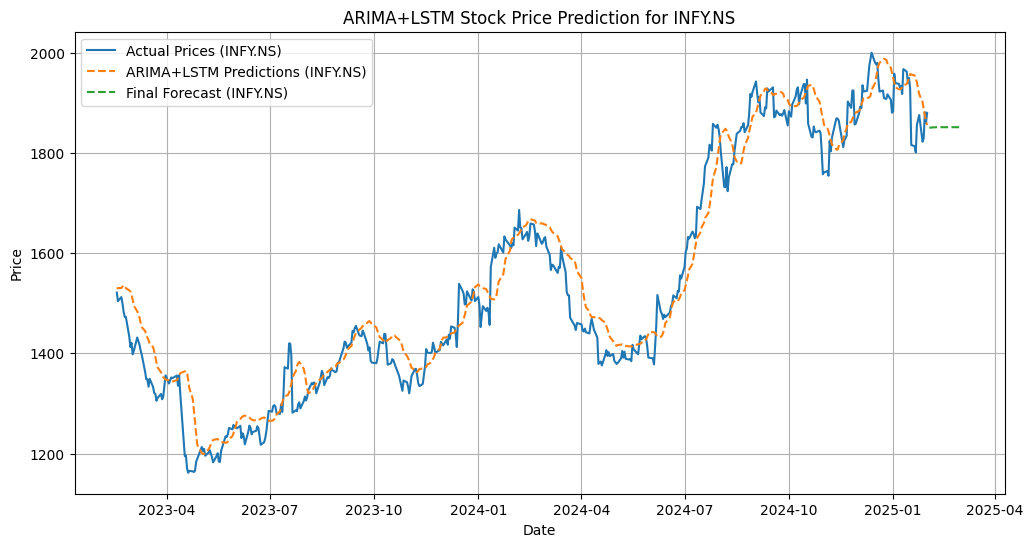

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step


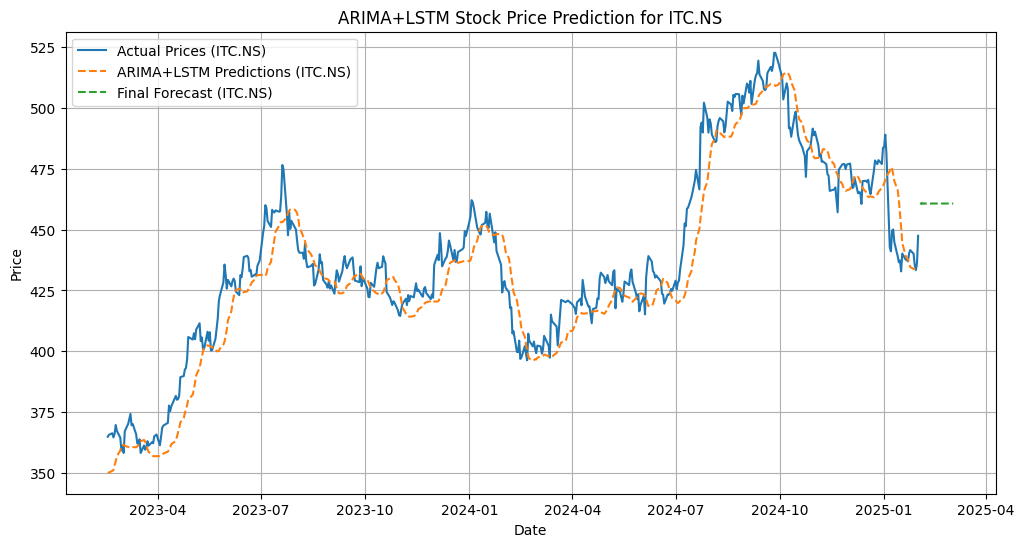

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


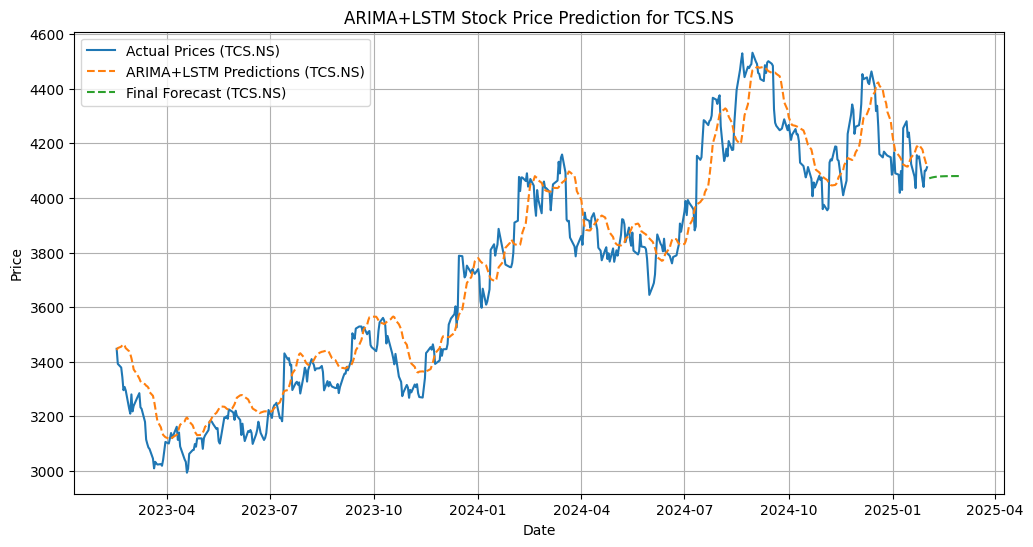

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


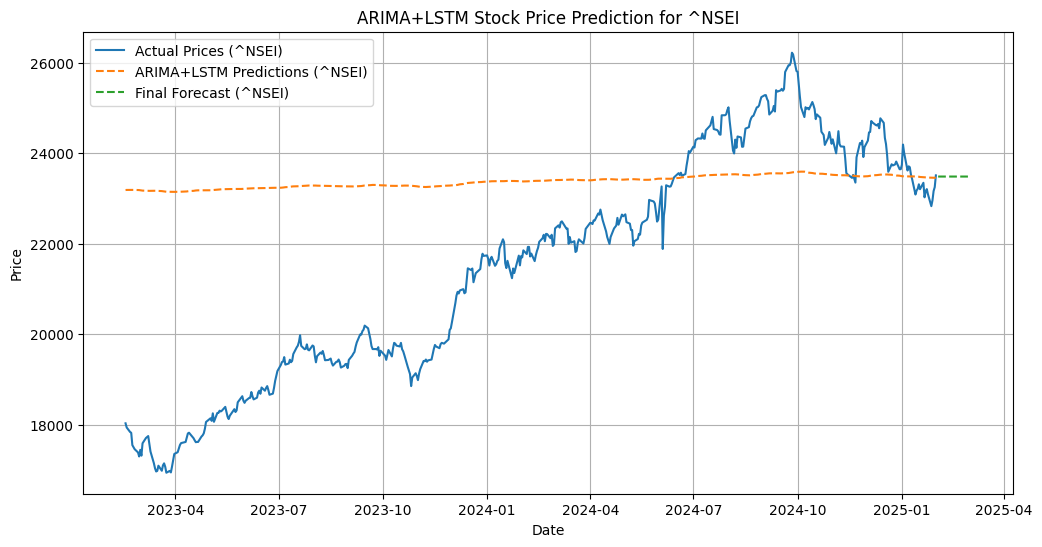

In [ ]:



forecast_results = {}

for column in test_data.columns:
    if not column.endswith('_diff_residuals') and not column.endswith('_diff'):
        # Step 1: ARIMA Forecast on Test Data
        arima_forecast = arima_models_test[column].forecast(steps=len(test_data))  # Forecast using ARIMA
        arima_forecast = np.array(arima_forecast).flatten()  # Ensure correct shape
        arima_forecast_final = arima_models_test[column].forecast(steps = len(test_data +30))
        arima_forecast_final = np.array(arima_forecast_final).flatten()  # Ensure correct shape


        # Step 2: Calculate the residuals for the ARIMA forecast on the test data
        actual_values = test_data[column].values
        residuals = actual_values - arima_forecast  # Residuals = Actual - ARIMA prediction

        # Add the residuals to the test data
        residual_column = f"{column}_residuals"
        test_data[residual_column] = residuals

        # Step 3: Scale the residuals for LSTM input
        test_data[residual_column] = scaler.transform(test_data[residual_column].values.reshape(-1, 1))  # Scale the residuals

        # Step 4: Create LSTM dataset for residuals in test data
        X_test, y_test = create_lstm_dataset(test_data[residual_column].values, look_back=10)
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # Reshaping for LSTM input

        # Step 5: Predict using LSTM on residuals
        lstm_predictions = lstm_models[column].predict(X_test)
        lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1)).flatten()  # Inverse scaling



        # Step 6: Combine ARIMA forecast and LSTM residual predictions
        final_predictions = arima_forecast[:len(lstm_predictions)] + lstm_predictions

        final_forecast = arima_forecast_final[:((len(lstm_predictions))+30)]


        # Step 7: Evaluate the model performance
        mape, rmse, mase = evaluate_model(actual_values[10:10+len(final_predictions)], final_predictions)

        forecast_results[column] = {
            'MAPE': mape,
            'RMSE': rmse,
            'MASE': mase,
            'Final Prediction': arima_forecast[-1],
            'Actual': actual_values[10+len(final_predictions)]
        }

        # Step 8: Plot the results
        plt.figure(figsize=(12, 6))
        plt.plot(test_data.index[10:10+len(final_predictions)], actual_values[10:10+len(final_predictions)], label=f"Actual Prices ({column})")
        plt.plot(test_data.index[10:10+len(final_predictions)], final_predictions, label=f"ARIMA+LSTM Predictions ({column})", linestyle='dashed')
        forecast_index = pd.date_range(start=test_data.index[-1], periods=31, freq=test_data.index.freq)  # Create future dates
        plt.plot(forecast_index[1:], final_forecast[:30], label=f"Final Forecast ({column})", linestyle='dashed')  # Plot with the future dates

        plt.title(f"ARIMA+LSTM Stock Price Prediction for {column}")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.show()



In [ ]:
for ticker, results in forecast_results.items():
    print(f"Performance for {ticker}:")
    print(f"MAPE: {results['MAPE']:.2f}")
    print(f"RMSE: {results['RMSE']:.2f}")
    print(f"MASE: {results['MASE']:.2f}")
    print(f"Final Prediction: {results['Final Prediction']:.2f}")
    print(f"Actual: {results['Actual']:.2f}")

    # Financial Advice based on the forecasted value
    forecasted_end_value = results['Final Prediction']
    print("\nFinancial Analysis:")

    # Example analysis based on the forecasted value (for illustration, use stock data or other indicators)
    if forecasted_end_value > results['Actual']:
        print("The forecast indicates a potential upward trend in the stock/index, which might suggest a 'BUY' recommendation.")
    else:
        print("The forecast indicates a potential downward trend in the stock/index, which might suggest a 'SELL' recommendation.")



Performance for INFY.NS:
MAPE: 0.03
RMSE: 53.40
MASE: 0.20
Final Prediction: 1851.12
Actual: 1851.35

Financial Analysis:
The forecast indicates a potential downward trend in the stock/index, which might suggest a 'SELL' recommendation.
Performance for ITC.NS:
MAPE: 0.02
RMSE: 11.99
MASE: 0.33
Final Prediction: 460.75
Actual: 462.55

Financial Analysis:
The forecast indicates a potential downward trend in the stock/index, which might suggest a 'SELL' recommendation.
Performance for TCS.NS:
MAPE: 0.02
RMSE: 108.74
MASE: 0.24
Final Prediction: 4080.21
Actual: 4073.15

Financial Analysis:
The forecast indicates a potential upward trend in the stock/index, which might suggest a 'BUY' recommendation.
Performance for ^NSEI:
MAPE: 0.12
RMSE: 3007.09
MASE: 1.11
Final Prediction: 23482.67
Actual: 23482.15

Financial Analysis:
The forecast indicates a potential upward trend in the stock/index, which might suggest a 'BUY' recommendation.
